In [27]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

In [4]:
train_data = pd.read_csv('train999.csv')
test_data = pd.read_csv('test999.csv')

In [6]:
# Функция для распаковки данных
def extract_keys_values(row):
    keys = row['keys'] if isinstance(row['keys'], list) else json.loads(row['keys'].replace("'", "\""))
    values = row['values'] if isinstance(row['values'], list) else json.loads(row['values'].replace("'", "\""))
    flat_keys = [item for sublist in keys for item in sublist]
    flat_values = [float(item) if item != 'null' else None for sublist in values for item in sublist]
    return pd.Series(flat_values, index=flat_keys)

In [7]:
# Распаковка и объединение данных
train_data_extracted = train_data.apply(extract_keys_values, axis=1)
test_data_extracted = test_data.apply(extract_keys_values, axis=1)

train_data_combined = pd.concat([train_data.drop(columns=['keys', 'values']), train_data_extracted], axis=1)
test_data_combined = pd.concat([test_data.drop(columns=['keys', 'values']), test_data_extracted], axis=1)

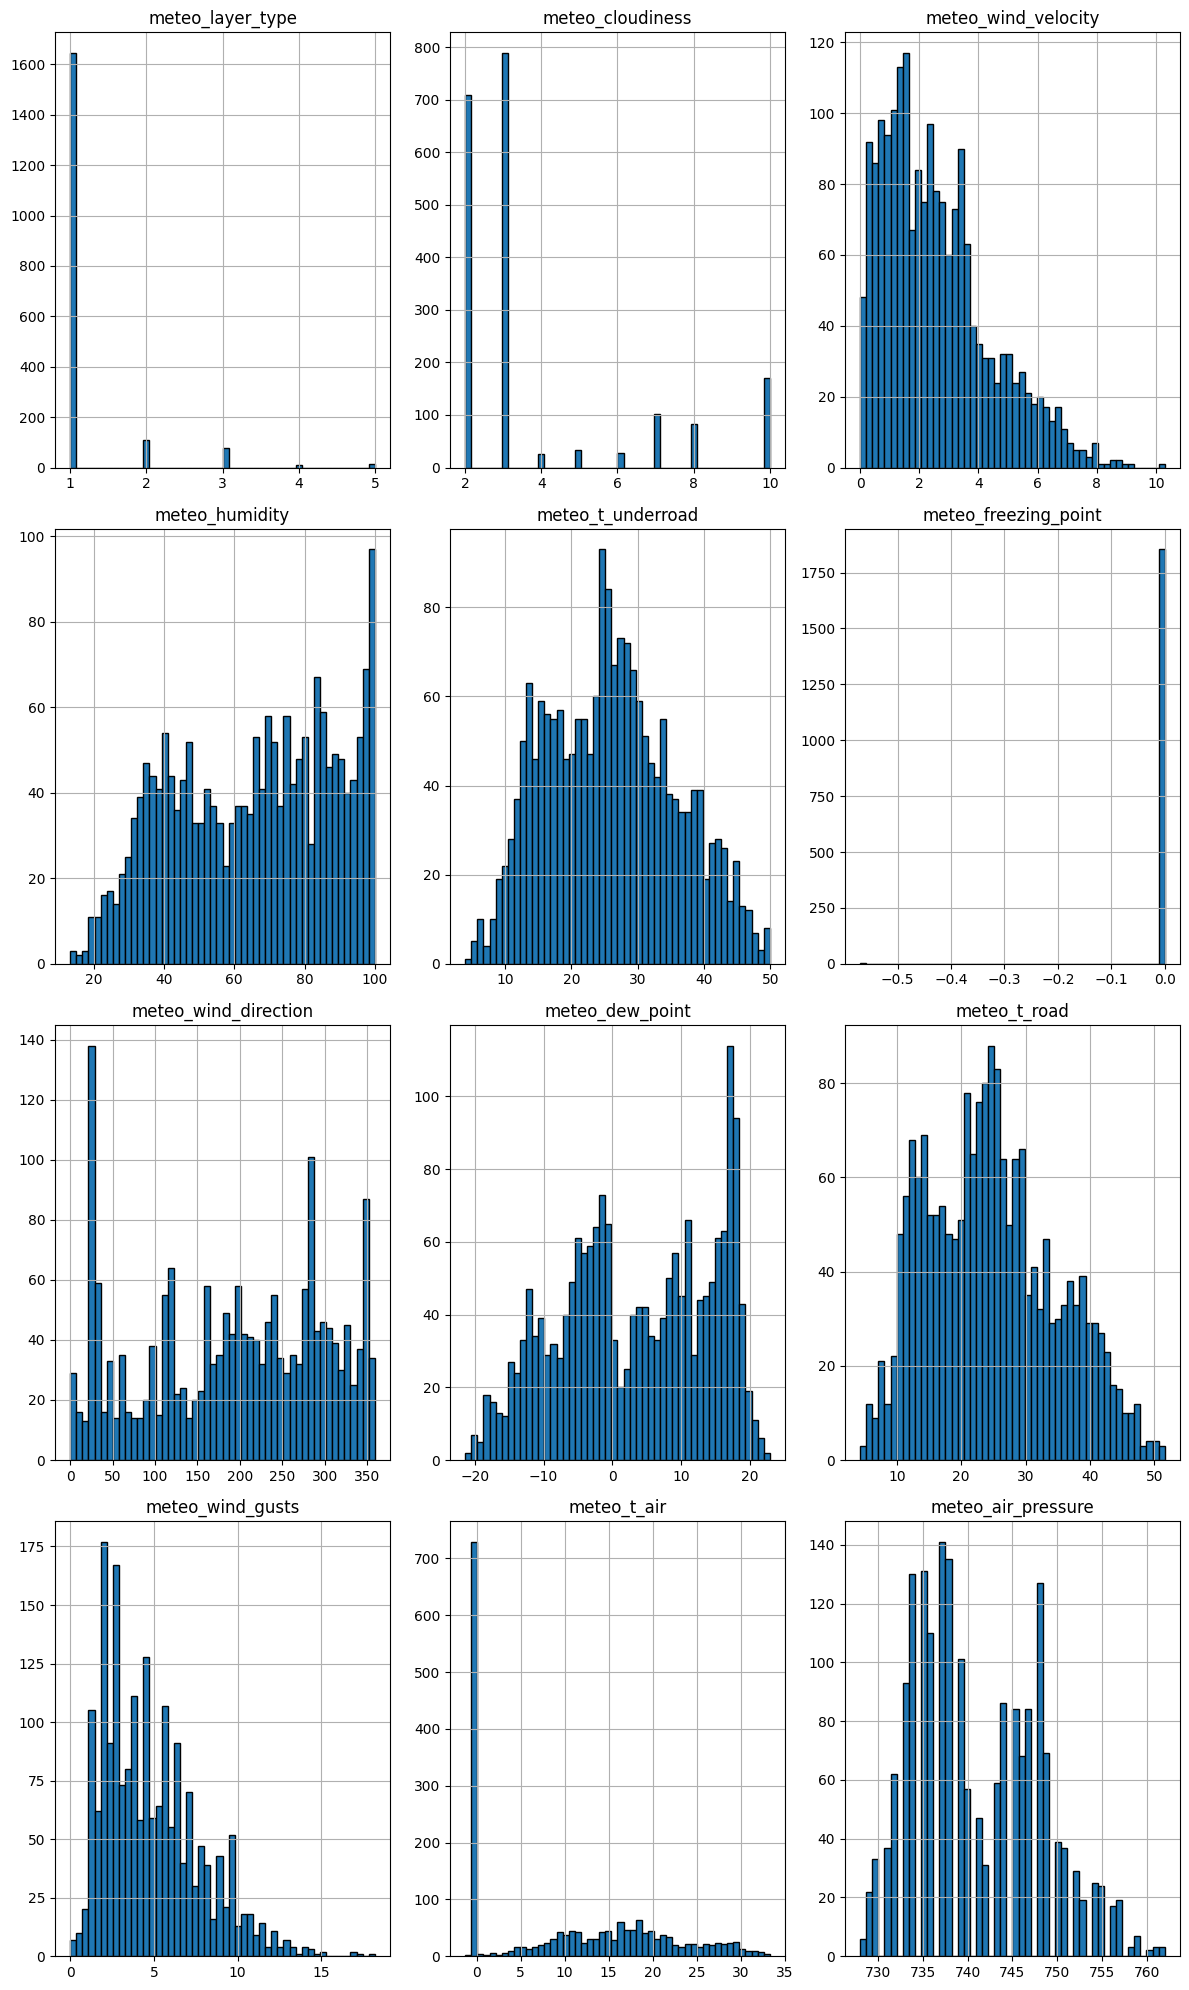

In [16]:
num_columns = 3
num_rows = int(np.ceil(len(train_data_extracted.columns) / num_columns))

fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 5 * num_rows))

for i, column in enumerate(train_data_extracted.columns):
    row = i // num_columns
    col = i % num_columns
    axes[row, col].hist(train_data_extracted[column].dropna(), bins=50, edgecolor='k')
    axes[row, col].set_title(f'{column}')
    axes[row, col].grid(True)

plt.tight_layout()
plt.show()

In [18]:
# Заполняем пропуски
imputer = SimpleImputer(strategy='median')
train_data_imputed = pd.DataFrame(imputer.fit_transform(train_data_extracted), columns=train_data_extracted.columns)
test_data_imputed = pd.DataFrame(imputer.transform(test_data_extracted), columns=test_data_extracted.columns)


In [19]:
# Создаем скользящие средние и стандартные отклонения
window_size = 3
for col in train_data_extracted.columns:
    train_data_imputed[f'{col}_rolling_mean'] = train_data_imputed[col].rolling(window=window_size).mean().fillna(train_data_imputed[col].mean())
    train_data_imputed[f'{col}_rolling_std'] = train_data_imputed[col].rolling(window=window_size).std().fillna(train_data_imputed[col].std())
    test_data_imputed[f'{col}_rolling_mean'] = test_data_imputed[col].rolling(window=window_size).mean().fillna(test_data_imputed[col].mean())
    test_data_imputed[f'{col}_rolling_std'] = test_data_imputed[col].rolling(window=window_size).std().fillna(test_data_imputed[col].std())

In [20]:
# Объединяем с новыми признаками
all_columns = train_data_imputed.columns

In [21]:
# Масштабируем данные
scaler = RobustScaler()
scaled_train_data = scaler.fit_transform(train_data_imputed)
scaled_test_data = scaler.transform(test_data_imputed)

In [22]:
# Обучаем модель
model = DBSCAN(eps=0.2, min_samples=12, n_jobs=-1)
train_anomalies = pd.DataFrame()
test_anomalies = pd.DataFrame()

for column in train_data_extracted.columns:
    model.fit(scaled_train_data[:, train_data_extracted.columns.get_loc(column)].reshape(-1, 1))
    train_anomalies[column] = model.labels_
    model.fit(scaled_test_data[:, train_data_extracted.columns.get_loc(column)].reshape(-1, 1))
    test_anomalies[column] = model.labels_


In [23]:
# Конвертируем метки и помечаем NaN как аномалии

train_anomalies = (train_anomalies == -1).astype(int)
test_anomalies = (test_anomalies == -1).astype(int)

for column in train_data_extracted.columns:
    train_anomalies[column] = np.where(train_data_extracted[column].isna(), 1, train_anomalies[column])
    test_anomalies[column] = np.where(test_data_extracted[column].isna(), 1, test_anomalies[column])

In [24]:
# Объединяем по ID
train_anomalies = pd.concat([train_data_combined[['id']], train_anomalies], axis=1)
test_anomalies = pd.concat([test_data_combined[['id']], test_anomalies], axis=1)

In [25]:
# Функция для создания нужного формата для столбца target
def create_target(df):
    df['target'] = df.drop(columns=['id']).apply(lambda row: '[' + ', '.join(row.astype(str)) + ']', axis=1)
    return df[['id', 'target']]

In [32]:
# Создаем результирующий датасет и сохраняем в файл
train_result = create_target(train_anomalies)
test_result = create_target(test_anomalies)

test_result.to_csv('test_anomalies.csv', index=False)
